In [70]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

np.random.seed(42)

In [2]:
day = 16 # день рождения
n_features = 10
n_classes = 3 + day//5
n_samples = 1000

In [ ]:
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=8, n_redundant=0, n_classes=n_classes, random_state=42)

In [4]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.070729,0.011901,-0.165015,-0.038457,0.188988,0.071647,-0.016983,0.489056,-0.033323,-0.004851
std,1.998412,1.979822,1.969760,1.834454,1.778872,1.882340,1.013667,1.851486,1.976146,0.993583
min,-7.409478,-6.403031,-6.263850,-7.376715,-5.415565,-5.856612,-4.054050,-5.561504,-6.035980,-2.706518
25%,-1.406289,-1.307162,-1.482332,-1.176715,-0.971578,-1.113012,-0.701885,-0.610556,-1.372909,-0.707399
50%,-0.018896,-0.027646,-0.184553,-0.011929,0.150210,0.155191,0.033943,0.643021,-0.076731,-0.001391
75%,1.285955,1.255757,1.171635,1.263112,1.375263,1.420308,0.671166,1.694812,1.361499,0.653904
max,6.208213,6.185867,5.383358,4.793406,5.676245,6.377722,2.784588,5.236315,6.547105,2.715149


In [5]:
pd.DataFrame(y).describe()

,0
count,1000.000000
mean,2.495000
std,1.709063
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,5.000000


In [6]:
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
 9   9       1000 non-null   float64
dtypes: float64(10)
memory usage: 78.3 KB


In [7]:
pd.DataFrame(y).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB


In [8]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
sc = StandardScaler().fit(X_tr)

In [10]:
X_tr = sc.transform(X_tr)
X_te =  sc.transform(X_te) 

In [11]:
def _sigmoid(z):
    z = np.clip(z, -40, 40)
    return 1.0 / (1.0 + np.exp(-z))

In [12]:
def _add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

In [13]:
def fit_logreg_binary(X, y, lr=0.1, epochs=1000, l2=0.0, tol=1e-8, verbose=False, return_history=False):
    Xb = _add_bias(X)
    n, d = Xb.shape
    w = np.zeros(d)
    history = []

    for t in range(epochs):
        logits = Xb @ w
        p = _sigmoid(logits)
        grad = (Xb.T @ (p - y)) / n
        grad[:-1] += l2 * w[:-1]

        w_prev = w.copy()
        w -= lr * grad

        if return_history:
            eps = 1e-12
            loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)) + 0.5*l2*np.sum(w[:-1]**2)
            history.append(loss)

        if np.linalg.norm(w - w_prev) < tol:
            if verbose:
                print(f"Stopped at epoch {t}")
            break

    return (w, history) if return_history else w

In [14]:
def predict_proba_logreg_binary(X, w):
    Xb = _add_bias(X)
    return _sigmoid(Xb @ w)

In [15]:
def decision_function_logreg_binary(X, w):
    Xb = _add_bias(X)
    return Xb @ w

### One-vs-Rest

In [16]:
def fit_ovr(X, y, classes=None, **logreg_kwargs):

    if classes is None:
        classes = np.unique(y)
    classes_ = np.array(classes)

    weights = []
    for c in classes_:
        y_bin = (y == c).astype(np.float64)
        w = fit_logreg_binary(X, y_bin, **logreg_kwargs)
        weights.append(w)
    return {"classes_": classes_, "weights_": weights}

In [17]:
def predict_proba_ovr(X, model):
    classes_ = model["classes_"]
    weights_ = model["weights_"]
    P = np.column_stack([predict_proba_logreg_binary(X, w) for w in weights_])
    P = P / (P.sum(axis=1, keepdims=True) + 1e-12)
    return P, classes_

In [18]:
def predict_ovr(X, model):
    P, classes_ = predict_proba_ovr(X, model)
    idx = np.argmax(P, axis=1)
    return classes_[idx]

### One-vs-One

In [19]:
def fit_ovo(X, y, classes=None, **logreg_kwargs):
    if classes is None:
        classes = np.unique(y)
    classes_ = np.array(classes)

    pair_models = {}
    for ci, cj in combinations(classes_, 2):
        mask = (y == ci) | (y == cj)
        X_ij = X[mask]
        y_ij = (y[mask] == ci).astype(np.float64)
        w = fit_logreg_binary(X_ij, y_ij, **logreg_kwargs)
        pair_models[(ci, cj)] = w
    return {"classes_": classes_, "pair_models_": pair_models}

In [20]:
def predict_ovo(X, model):
    classes_ = model["classes_"]
    pair_models = model["pair_models_"]
    n = X.shape[0]
    votes = np.zeros((n, len(classes_)), dtype=np.int64)
    scores = np.zeros((n, len(classes_)), dtype=np.float64)  # для тай-брейка
    class_to_idx = {c: i for i, c in enumerate(classes_)}

    for (ci, cj), w in pair_models.items():
        logit = decision_function_logreg_binary(X, w)
        mask_ci = logit >= 0.0
        mask_cj = ~mask_ci
        i_ci = class_to_idx[ci]
        i_cj = class_to_idx[cj]
        votes[mask_ci, i_ci] += 1
        votes[mask_cj, i_cj] += 1
        scores[:, i_ci] += np.clip(logit, 0, None)
        scores[:, i_cj] += np.clip(-logit, 0, None)

    winners = np.zeros(n, dtype=classes_.dtype)
    for i in range(n):
        max_votes = votes[i].max()
        candidates = np.where(votes[i] == max_votes)[0]
        if len(candidates) == 1:
            winners[i] = classes_[candidates[0]]
        else:
            winner_idx = candidates[np.argmax(scores[i, candidates])]
            winners[i] = classes_[winner_idx]
    return winners

In [21]:
def _unique_classes(y):
    classes = np.unique(y)
    return classes

In [22]:
def _one_hot(y, classes=None):
    if classes is None:
        classes = _unique_classes(y)
    lookup = {c:i for i,c in enumerate(classes)}
    Y = np.zeros((len(y), len(classes)), dtype=np.float64)
    for i, yi in enumerate(y):
        Y[i, lookup[yi]] = 1.0
    return Y, np.asarray(classes)

In [23]:
def _safe_div(a, b):
    return a / np.clip(b, 1e-12, None)

In [24]:
def _auc_trapezoid(x, y):
    return np.trapezoid(y, x)

$$
Accuracy = \frac{TP+TN}{TP + TN+FP+FN} = \frac{\text{Correct predictions}}{\text{All predictions}}
$$

In [25]:
def accuracy_score_mc(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(y_true == y_pred)

$$
\begin{align}
\text{Precision} = \frac{TP}{TP + FP}\\
\text{Recall} = \frac{TP}{TP + FN}\\
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}  
\end{align}
$$

In [26]:
def precision_score(y_true, y_pred, cls):
    tp = np.sum((y_true == cls) & (y_pred == cls))
    fp = np.sum((y_true != cls) & (y_pred == cls))
    return tp / (tp + fp + 1e-12)

In [27]:
def recall_score(y_true, y_pred, cls):
    tp = np.sum((y_true == cls) & (y_pred == cls))
    fn = np.sum((y_true == cls) & (y_pred != cls))
    return tp / (tp + fn + 1e-12)

In [28]:
def f1_score(y_true, y_pred, cls):
    p = precision_score(y_true, y_pred, cls)
    r = recall_score(y_true, y_pred, cls)
    return 2 * p * r / (p + r + 1e-12)

$$
F_{1\;\text{macro}} = \frac{1}{K} \sum_{k=1}^{K} F_{1_{k}  } 
$$

In [29]:
def f1_macro(y_true, y_pred):
    classes = np.unique(y_true)
    f1_scores = [f1_score(y_true, y_pred, c) for c in classes]
    return np.mean(f1_scores)

$$
\begin{align}
\text{Precision}_{micro} = \frac{\sum\limits_k TP_k}{\sum\limits_k (TP_k + FP_k)} \\
\text{Recall}_{micro} = \frac{\sum\limits_k TP_k}{\sum\limits_k (TP_k + FN_k)} \\
F_{1\;micro} = 2 \cdot \frac{\text{Precision}_{micro} \cdot \text{Recall}_{micro}}{\text{Precision}_{micro} + \text{Recall}_{micro}}  
\end{align}
$$

In [30]:
def f1_micro(y_true, y_pred):
    classes = np.unique(y_true)
    tp = fp = fn = 0
    for c in classes:
        tp += np.sum((y_true == c) & (y_pred == c))
        fp += np.sum((y_true != c) & (y_pred == c))
        fn += np.sum((y_true == c) & (y_pred != c))
    P_micro = tp / (tp + fp + 1e-12)
    R_micro = tp / (tp + fn + 1e-12)
    return 2 * P_micro * R_micro / (P_micro + R_micro + 1e-12)

$$
\begin{align}
\text{TPR} = \frac{TP}{TP + FN}\\
\text{FPR} = \frac{FP}{FP + TN}\\
\text{ROC-AUC} = \int\limits_{0}^{1} TPR(FPR) \, d(FPR)
\end{align}
$$
(AUC - площадь под ROC-кривой)

In [31]:
def roc_curve_binary(y_true_bin, scores):
    y = np.asarray(y_true_bin, dtype=np.uint8)
    s = np.asarray(scores, dtype=np.float64)
    order = np.argsort(-s, kind="mergesort")
    y = y[order]
    s = s[order]
    P = int(np.sum(y))
    N = int(len(y) - P)

    if P == 0 or N == 0:
        return np.array([0.0, 1.0]), np.array([0.0, 1.0]), np.array([np.inf, -np.inf])

    tps = np.cumsum(y)
    fps = np.cumsum(1 - y)
    distinct = np.where(np.diff(s, prepend=np.inf))[0]
    tpr = tps[distinct] / P
    fpr = fps[distinct] / N
    thresholds = s[distinct]
    fpr = np.concatenate(([0.0], fpr, [1.0]))
    tpr = np.concatenate(([0.0], tpr, [1.0]))
    thresholds = np.concatenate(([np.inf], thresholds, [-np.inf]))

    return fpr, tpr, thresholds

In [32]:
def roc_auc_binary(y_true_bin, scores):
    fpr, tpr, _ = roc_curve_binary(y_true_bin, scores)
    return _auc_trapezoid(fpr, tpr)

OvR (One vs Rest)
$$
ROC\_AUC_{\text{macro}} = \frac{1}{K} \sum\limits_{k=1}^{K} ROC\_AUC_k  
$$

In [ ]:
def roc_auc_ovr(y_true, proba, average="macro"):
    y_true = np.asarray(y_true)
    proba  = np.asarray(proba, dtype=np.float64)
    classes = np.unique(y_true)
    K = len(classes)
    Y = np.zeros((len(y_true), K), dtype=np.uint8)

    for j, c in enumerate(classes):
        Y[:, j] = (y_true == c).astype(np.uint8)

    support = np.sum(Y, axis=0)
    aucs = np.full(K, np.nan, dtype=np.float64)

    for j in range(K):
        y_bin = Y[:, j]
        if np.all(y_bin == 0) or np.all(y_bin == 1):
            continue
        aucs[j] = roc_auc_binary(y_bin, proba[:, j])

    if average == "none":
        return aucs, classes

    mask = ~np.isnan(aucs)
    if not np.any(mask):
        return np.nan

    if average == "macro":
        return np.mean(aucs[mask])
    elif average == "weighted":
        w = support[mask]
        return np.sum(aucs[mask] * w) / (np.sum(w) + 1e-12)
    elif average == "micro":
        y_flat = Y.ravel()
        s_flat = proba.ravel()
        return roc_auc_binary(y_flat, s_flat)
    else:
        raise ValueError("average must be one of {'macro','weighted','micro','none'}")

OvO (One vs One)
$$
ROC\_AUC_{\text{ovo}} = \frac{2}{K(K-1)} \sum\limits_{i<j} ROC\_AUC(i,j)  
$$

In [34]:
def roc_auc_ovo(y_true, proba):
    y_true = np.asarray(y_true)
    proba  = np.asarray(proba, dtype=np.float64)
    classes = np.unique(y_true)
    K = len(classes)
    auc_sum = 0.0
    pairs = 0

    for a in range(K):
        for b in range(a + 1, K):
            ca, cb = classes[a], classes[b]
            mask = (y_true == ca) | (y_true == cb)
            if not np.any(mask):
                continue
            y_bin = (y_true[mask] == ca).astype(np.uint8)
            scores = proba[mask, a]
            if np.all(y_bin == 0) or np.all(y_bin == 1):
                continue
            auc_sum += roc_auc_binary(y_bin, scores)
            pairs += 1

    return (2.0 * auc_sum / (K * (K - 1))) if pairs > 0 else np.nan

$$  
PR\_AUC = \int\limits_{0}^{1} \text{Precision}(Recall) \, d(Recall)  
$$

In [35]:
def precision_recall_curve_binary(y_true_bin, scores):
    y = np.asarray(y_true_bin, dtype=np.uint8)
    s = np.asarray(scores, dtype=np.float64)
    order = np.argsort(-s, kind="mergesort")
    y = y[order]
    s = s[order]
    P = int(np.sum(y))

    if P == 0:
        return np.array([0.0, 1.0]), np.array([1.0, 0.0]), np.array([np.inf, -np.inf])

    tp = np.cumsum(y)
    fp = np.cumsum(1 - y)
    precision = _safe_div(tp, tp + fp)
    recall = _safe_div(tp, P)
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([1.0], precision, [0.0]))
    thresholds = np.concatenate(([np.inf], s, [-np.inf]))

    for i in range(len(precision) - 2, -1, -1):
        if precision[i] < precision[i + 1]:
            precision[i] = precision[i + 1]

    return recall, precision, thresholds

In [36]:
def pr_auc_binary(y_true_bin, scores):
    r, p, _ = precision_recall_curve_binary(y_true_bin, scores)
    return _auc_trapezoid(r, p)

$$
PR\_AUC_{\text{macro}} = \frac{1}{K} \sum\limits_{k=1}^{K} PR\_AUC_k  
$$

In [ ]:
def pr_auc_ovr(y_true, proba, average="macro"):
    y_true = np.asarray(y_true)
    proba  = np.asarray(proba, dtype=np.float64)
    classes = np.unique(y_true)
    K = len(classes)
    Y = np.zeros((len(y_true), K), dtype=np.uint8)

    for j, c in enumerate(classes):
        Y[:, j] = (y_true == c).astype(np.uint8)

    support = np.sum(Y, axis=0)
    ap = np.full(K, np.nan, dtype=np.float64)

    for j in range(K):
        y_bin = Y[:, j]
        if np.sum(y_bin) == 0:
            continue
        ap[j] = pr_auc_binary(y_bin, proba[:, j])

    if average == "none":
        return ap, classes

    mask = ~np.isnan(ap)

    if not np.any(mask):
        return np.nan

    if average == "macro":
        return np.mean(ap[mask])
    elif average == "weighted":
        w = support[mask]
        return np.sum(ap[mask] * w) / (np.sum(w) + 1e-12)
    elif average == "micro":
        y_flat = Y.ravel()
        s_flat = proba.ravel()
        return pr_auc_binary(y_flat, s_flat)
    else:
        raise ValueError("average must be one of {'macro','weighted','micro','none'}")

In [44]:
def f1_score_multiclass(y_true, y_pred, average='macro'):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    classes = np.unique(y_true)
    k = len(classes)

    tp = np.zeros(k)
    fp = np.zeros(k)
    fn = np.zeros(k)
    support = np.zeros(k)

    for i, c in enumerate(classes):
        tp[i] = np.sum((y_true == c) & (y_pred == c))
        fp[i] = np.sum((y_true != c) & (y_pred == c))
        fn[i] = np.sum((y_true == c) & (y_pred != c))
        support[i] = np.sum(y_true == c)

    precision = tp / np.clip(tp + fp, 1e-12, None)
    recall    = tp / np.clip(tp + fn, 1e-12, None)
    f1_class  = 2 * precision * recall / np.clip(precision + recall, 1e-12, None)

    if average == 'macro':
        return np.nanmean(f1_class)
    elif average == 'weighted':
        return np.nansum(f1_class * support) / np.sum(support)
    elif average == 'micro':
        TP = np.sum(tp)
        FP = np.sum(fp)
        FN = np.sum(fn)
        P_micro = TP / np.clip(TP + FP, 1e-12, None)
        R_micro = TP / np.clip(TP + FN, 1e-12, None)
        return 2 * P_micro * R_micro / np.clip(P_micro + R_micro, 1e-12, None)
    else:
        raise ValueError("average must be one of {'macro','micro','weighted'}")


In [ ]:
def evaluate_ovr(X_tr, y_tr, X_te, y_te, **logreg_params):
    ovr_model = fit_ovr(X_tr, y_tr, **logreg_params)
    y_pred = predict_ovr(X_te, ovr_model)
    P_te, classes_ = predict_proba_ovr(X_te, ovr_model)
    acc     = accuracy_score_mc(y_te, y_pred)
    f1_mac  = f1_score_multiclass(y_te, y_pred, average='macro')
    f1_mic  = f1_score_multiclass(y_te, y_pred, average='micro')
    f1_w    = f1_score_multiclass(y_te, y_pred, average='weighted')
    roc_mac = roc_auc_ovr(y_te, P_te, average='macro')
    roc_w   = roc_auc_ovr(y_te, P_te, average='weighted')
    roc_mic = roc_auc_ovr(y_te, P_te, average='micro')
    pr_mac  = pr_auc_ovr(y_te, P_te, average='macro')
    pr_w    = pr_auc_ovr(y_te, P_te, average='weighted')
    pr_mic  = pr_auc_ovr(y_te, P_te, average='micro')

    return {
        "model": "OvR",
        "accuracy": acc,
        "f1_macro": f1_mac,
        "f1_micro": f1_mic,
        "f1_weighted": f1_w,
        "roc_auc_macro": roc_mac,
        "roc_auc_weighted": roc_w,
        "roc_auc_micro": roc_mic,
        "pr_auc_macro": pr_mac,
        "pr_auc_weighted": pr_w,
        "pr_auc_micro": pr_mic,
        "classes_": classes_,
        "proba_te": P_te,
        "y_pred": y_pred,
        "model_obj": ovr_model,
    }


def evaluate_ovo(X_tr, y_tr, X_te, y_te, **logreg_params):
    def _pairwise_probs(ovo_model, X):
        import numpy as np
        def _sigmoid(z):
            z = np.clip(z, -40, 40)
            return 1.0 / (1.0 + np.exp(-z))
        classes_ = ovo_model["classes_"]
        pair_models = ovo_model["pair_models_"]
        K = len(classes_)
        n = X.shape[0]
        Xb = np.hstack([X, np.ones((n, 1))])
        class_to_idx = {c:i for i,c in enumerate(classes_)}
        S_sum = np.zeros((n, K), dtype=float)
        cnt   = np.zeros((K,), dtype=int)

        for (ci, cj), w in pair_models.items():
            i = class_to_idx[ci]
            j = class_to_idx[cj]
            logit = Xb @ w
            p_ci = _sigmoid(logit)
            p_cj = 1.0 - p_ci
            S_sum[:, i] += p_ci
            S_sum[:, j] += p_cj
            cnt[i] += 1
            cnt[j] += 1

        S_mean = S_sum / (cnt[None, :] + 1e-12)
        P_norm = S_mean / (np.sum(S_mean, axis=1, keepdims=True) + 1e-12)
        return S_mean, P_norm, classes_

    ovo_model = fit_ovo(X_tr, y_tr, **logreg_params)
    y_pred = predict_ovo(X_te, ovo_model)
    S_mean, P_norm, classes_ = _pairwise_probs(ovo_model, X_te)
    acc     = accuracy_score_mc(y_te, y_pred)
    f1_mac  = f1_score_multiclass(y_te, y_pred, average='macro')
    f1_mic  = f1_score_multiclass(y_te, y_pred, average='micro')
    f1_w    = f1_score_multiclass(y_te, y_pred, average='weighted')
    roc_ovo = roc_auc_ovo(y_te, P_norm)
    roc_mac = roc_auc_ovr(y_te, P_norm, average='macro')
    roc_w   = roc_auc_ovr(y_te, P_norm, average='weighted')
    roc_mic = roc_auc_ovr(y_te, P_norm, average='micro')
    pr_mac  = pr_auc_ovr(y_te, P_norm, average='macro')
    pr_w    = pr_auc_ovr(y_te, P_norm, average='weighted')
    pr_mic  = pr_auc_ovr(y_te, P_norm, average='micro')

    return {
        "model": "OvO",
        "accuracy": acc,
        "f1_macro": f1_mac,
        "f1_micro": f1_mic,
        "f1_weighted": f1_w,
        "roc_auc_ovo": roc_ovo,
        "roc_auc_macro": roc_mac,
        "roc_auc_weighted": roc_w,
        "roc_auc_micro": roc_mic,
        "pr_auc_macro": pr_mac,
        "pr_auc_weighted": pr_w,
        "pr_auc_micro": pr_mic,
        "classes_": classes_,
        "proba_te": P_norm,
        "y_pred": y_pred,
        "model_obj": ovo_model,
    }


In [46]:

def class_report(y_true, y_pred, proba=None, classes=None, title=""):
    if classes is None:
        classes = np.unique(y_true)

    print("\n" + "="*10 + f" {title} " + "="*10)
    print("Class | Support | Prec  | Rec   | F1    | ROC_AUC_k| PR_AUC_k")

    for i, c in enumerate(classes):
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        sup = np.sum(y_true == c)
        prec = tp / (tp + fp + 1e-12)
        rec  = tp / (tp + fn + 1e-12)
        f1   = 2 * prec * rec / (prec + rec + 1e-12)

        if proba is not None:
            y_bin = (y_true == c).astype(np.uint8)
            scores = proba[:, i]
            if np.any(y_bin == 1) and np.any(y_bin == 0):
                roc_k = roc_auc_binary(y_bin, scores)
                pr_k  = pr_auc_binary(y_bin, scores)
            else:
                roc_k = np.nan
                pr_k  = np.nan
            print(f"{c:>5} | {sup:>7} | {prec:>4.3f} | {rec:>4.3f} | {f1:>4.3f} | {roc_k:>8.3f} | {pr_k:>8.3f}")
        else:
            print(f"{c:>5} | {sup:>7} | {prec:>4.3f} | {rec:>4.3f} | {f1:>4.3f}")

    counts = np.array([np.sum(y_true == c) for c in classes], dtype=float)
    imbalance_ratio = counts.max() / (counts.min() + 1e-12)
    print(f"\nImbalance ratio (max/min support): {imbalance_ratio:.2f}")

    if imbalance_ratio >= 3:
        print("Сильный дисбаланс — ориентируйтесь на macro/weighted F1 и AUC.")
    elif imbalance_ratio >= 1.5:
        print("ℹУмеренный дисбаланс — проверяйте редкие классы отдельно.")
    else:
        print("Классы относительно сбалансированы.")


In [47]:
%%time
logreg_params = dict(lr=0.2, epochs=2000, l2=1e-4, tol=1e-7, verbose=False)
res_ovr = evaluate_ovr(X_tr, y_tr, X_te, y_te, **logreg_params)

CPU times: total: 359 ms
Wall time: 363 ms


In [48]:
%%time
res_ovo = evaluate_ovo(X_tr, y_tr, X_te, y_te, **logreg_params)

CPU times: total: 750 ms
Wall time: 749 ms


In [41]:
%timeit evaluate_ovr(X_tr, y_tr, X_te, y_te, **logreg_params)
%timeit evaluate_ovo(X_tr, y_tr, X_te, y_te, **logreg_params)

374 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
774 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
print("\n=== Итоги: точность и AUC ===")
print("OvR:", res_ovr["accuracy"], res_ovr["f1_macro"], res_ovr["roc_auc_macro"], res_ovr["pr_auc_macro"])
print("OvO:", res_ovo["accuracy"], res_ovo["f1_macro"], res_ovo["roc_auc_macro"], res_ovo["pr_auc_macro"])
class_report(y_te, res_ovr["y_pred"], proba=res_ovr["proba_te"], classes=res_ovr["classes_"], title="OvR per-class report (test)")
class_report(y_te, res_ovo["y_pred"], proba=res_ovo["proba_te"], classes=res_ovo["classes_"], title="OvO per-class report (test)")



=== Итоги: точность и AUC ===
OvR: 0.54 0.5363056693722207 0.8542579703252687 0.6204740359520121
OvO: 0.57 0.5669752208389806 0.8562058281478406 0.6192226107771858

========== OvR per-class report (test) ==========
Class | Support | Prec  | Rec   | F1    | ROC_AUC_k| PR_AUC_k
    0 |      33 | 0.528 | 0.576 | 0.551 |    0.918 |    0.673
    1 |      34 | 0.426 | 0.588 | 0.494 |    0.819 |    0.519
    2 |      33 | 0.618 | 0.636 | 0.627 |    0.851 |    0.683
    3 |      34 | 0.500 | 0.294 | 0.370 |    0.828 |    0.516
    4 |      33 | 0.636 | 0.636 | 0.636 |    0.882 |    0.684
    5 |      33 | 0.567 | 0.515 | 0.540 |    0.827 |    0.648

Imbalance ratio (max/min support): 1.03
Классы относительно сбалансированы.

========== OvO per-class report (test) ==========
Class | Support | Prec  | Rec   | F1    | ROC_AUC_k| PR_AUC_k
    0 |      33 | 0.636 | 0.636 | 0.636 |    0.909 |    0.676
    1 |      34 | 0.477 | 0.618 | 0.538 |    0.844 |    0.571
    2 |      33 | 0.677 | 0.636 | 0.

In [65]:
def plot_metrics_comparison(res_ovr, res_ovo):
    metrics = ['accuracy', 'f1_macro', 'roc_auc_macro', 'pr_auc_macro']
    ovr_vals = [res_ovr[m] for m in metrics]
    ovo_vals = [res_ovo[m] for m in metrics]
    
    x = range(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar([i - width/2 for i in x], ovr_vals, width, label='OvR', alpha=0.8)
    ax.bar([i + width/2 for i in x], ovo_vals, width, label='OvO', alpha=0.8)
    
    ax.set_ylabel('Значение метрики')
    ax.set_title('Сравнение методов OvR и OvO')
    ax.set_xticks(x)
    ax.set_xticklabels(['Accuracy', 'F1-macro', 'ROC-AUC', 'PR-AUC'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


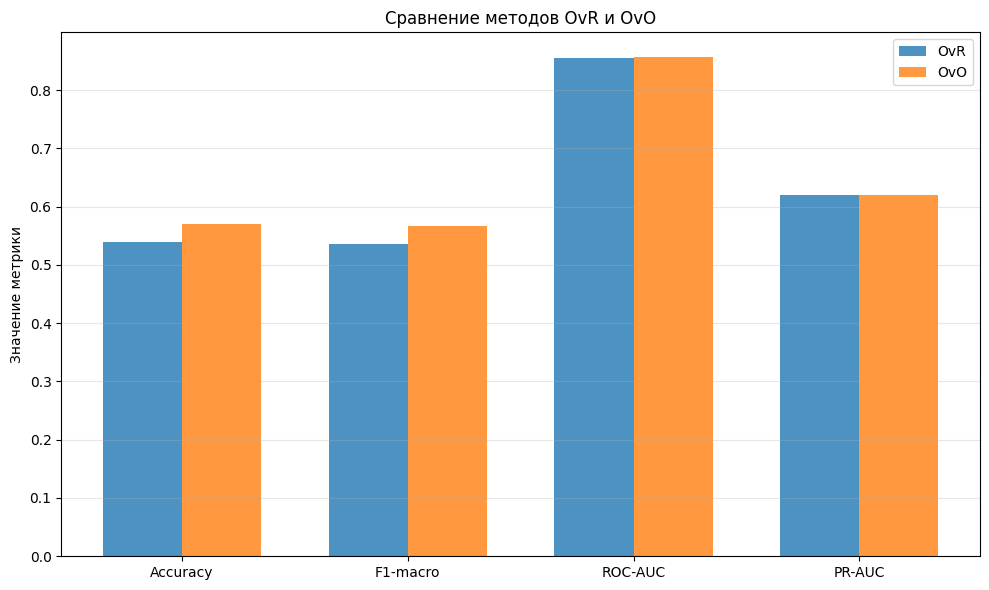

In [67]:
plot_metrics_comparison(res_ovr, res_ovo)

In [66]:
def plot_confusion_matrices(y_te, res_ovr, res_ovo):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for ax, res, title in zip(axes, [res_ovr, res_ovo], ['OvR', 'OvO']):
        cm = confusion_matrix(y_te, res['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                    xticklabels=res['classes_'], yticklabels=res['classes_'])
        ax.set_title(f'Матрица ошибок: {title}')
        ax.set_ylabel('Истинный класс')
        ax.set_xlabel('Предсказанный класс')
    
    plt.tight_layout()
    plt.show()

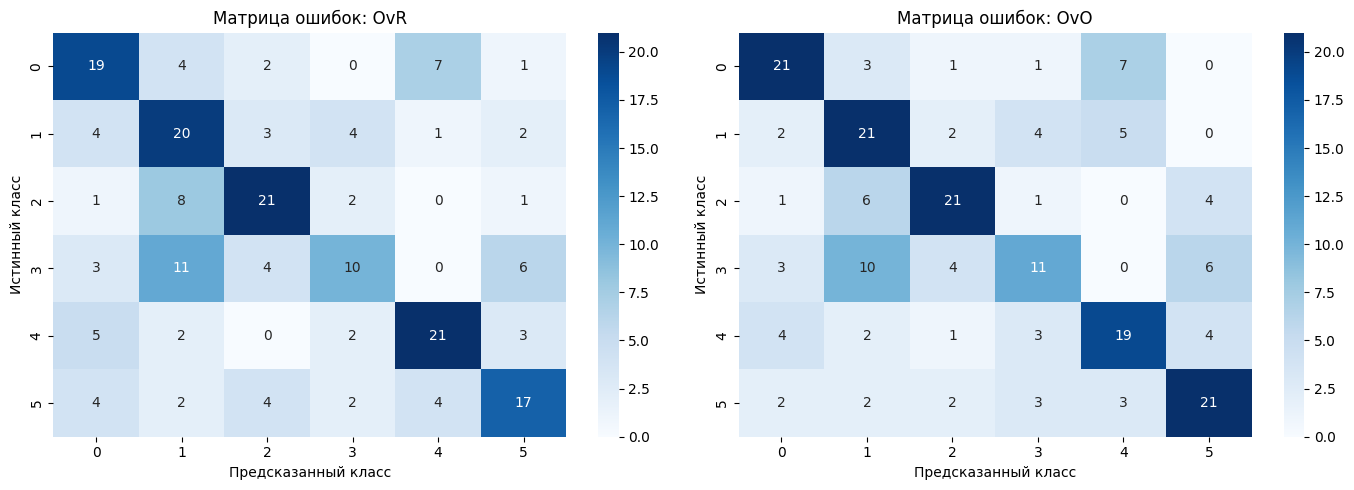

In [68]:
plot_confusion_matrices(y_te, res_ovr, res_ovo)

---

### 4\*

In [51]:
def create_imbalanced_dataset(n_samples=1000, n_features=10, n_classes=6, imbalance_ratio=5):    
    X, y = make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=8,
        n_redundant=0, 
        n_classes=n_classes, 
        random_state=42
    )
    
    total = len(y)
    unique_classes = np.unique(y)
    n_cls = len(unique_classes)
    min_samples = int(total / (sum(imbalance_ratio**(i/(n_cls-1)) for i in range(n_cls)))) # Геометрическая прогрессия для создания дисбаланса
    target_counts = [int(min_samples * imbalance_ratio**(i/(n_cls-1))) for i in range(n_cls)]
    diff = total - sum(target_counts)
    target_counts[-1] += diff
    indices_to_keep = []

    for cls_id, target_count in zip(unique_classes, target_counts):
        cls_indices = np.where(y == cls_id)[0]
        if len(cls_indices) > target_count:
            selected = np.random.choice(cls_indices, target_count, replace=False)
        else:
            selected = cls_indices
        indices_to_keep.extend(selected)
    
    indices_to_keep = np.array(indices_to_keep)
    np.random.shuffle(indices_to_keep)
    
    return X[indices_to_keep], y[indices_to_keep]

In [52]:
X_imb, y_imb = create_imbalanced_dataset(
    n_samples=1000,
    n_features=10,
    n_classes=n_classes,
    imbalance_ratio=5
)


In [54]:
print(f"\nДатасет: {X_imb.shape[0]} примеров, {X_imb.shape[1]} признаков, {n_classes} классов")
print(f"\nРаспределение классов:")

unique, counts = np.unique(y_imb, return_counts=True)
for cls, cnt in zip(unique, counts):
    bar = '|||' * int(cnt / counts.max() * 40)
    print(f"  Класс {cls}: {cnt:>4} ({cnt/len(y_imb)*100:>5.1f}%) {bar}")

imbalance_ratio = counts.max() / counts.min()
print(f"\n  Коэффициент дисбаланса: {imbalance_ratio:.2f}:1")
print(f"    Самый частый класс: {unique[counts.argmax()]} ({counts.max()} примеров)")
print(f"    Самый редкий класс: {unique[counts.argmin()]} ({counts.min()} примеров)")


Датасет: 772 примеров, 10 признаков, 6 классов

Распределение классов:
  Класс 0:   64 (  8.3%) |||||||||||||||||||||||||||||||||||||||||||||
  Класс 1:   88 ( 11.4%) ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
  Класс 2:  121 ( 15.7%) ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
  Класс 3:  168 ( 21.8%) ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
  Класс 4:  164 ( 21.2%) |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
  Класс 5:  167 ( 21.6%) |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

  Коэффициент дисбаланса: 2.62:1
    Самый частый класс: 3 (168 примеров)
    Самый редкий класс: 0 (64 примеров)


In [55]:
X_tr_imb, X_te_imb, y_tr_imb, y_te_imb = train_test_split(
    X_imb, y_imb, test_size=0.2, random_state=42, stratify=y_imb
)

In [56]:
scaler_imb = StandardScaler()
X_tr_imb = scaler_imb.fit_transform(X_tr_imb)
X_te_imb = scaler_imb.transform(X_te_imb)

In [57]:
%%time
res_imb_baseline_ovr = evaluate_ovr(X_tr_imb, y_tr_imb, X_te_imb, y_te_imb, **logreg_params)
res_imb_baseline_ovo = evaluate_ovo(X_tr_imb, y_tr_imb, X_te_imb, y_te_imb, **logreg_params)


CPU times: total: 1.09 s
Wall time: 1.14 s


In [59]:
print("\nOvR:")
print(f"  Accuracy:     {res_imb_baseline_ovr['accuracy']:.4f}")
print(f"  F1-macro:     {res_imb_baseline_ovr['f1_macro']:.4f}")
print(f"  F1-weighted:  {res_imb_baseline_ovr['f1_weighted']:.4f}")
print(f"  ROC-AUC:      {res_imb_baseline_ovr['roc_auc_macro']:.4f}")

print("\nOvO:")
print(f"  Accuracy:     {res_imb_baseline_ovo['accuracy']:.4f}")
print(f"  F1-macro:     {res_imb_baseline_ovo['f1_macro']:.4f}")
print(f"  F1-weighted:  {res_imb_baseline_ovo['f1_weighted']:.4f}")
print(f"  ROC-AUC:      {res_imb_baseline_ovo['roc_auc_macro']:.4f}")


OvR:
  Accuracy:     0.5613
  F1-macro:     0.5528
  F1-weighted:  0.5574
  ROC-AUC:      0.8723

OvO:
  Accuracy:     0.5806
  F1-macro:     0.5851
  F1-weighted:  0.5801
  ROC-AUC:      0.8767


In [60]:
def undersample_majority(X, y):
    unique, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    
    indices = []
    for cls in unique:
        cls_indices = np.where(y == cls)[0]
        if len(cls_indices) > min_count:
            selected = np.random.choice(cls_indices, min_count, replace=False)
        else:
            selected = cls_indices
        indices.extend(selected)
    
    indices = np.array(indices)
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [61]:
X_tr_under, y_tr_under = undersample_majority(X_tr_imb, y_tr_imb)
print(f"Размер после undersampling: {len(y_tr_under)} примеров ({len(y_tr_under)/len(y_tr_imb)*100:.1f}% от исходного)")


Размер после undersampling: 306 примеров (49.6% от исходного)


In [62]:
%%time
res_imb_under_ovr = evaluate_ovr(X_tr_under, y_tr_under, X_te_imb, y_te_imb, **logreg_params)
res_imb_under_ovo = evaluate_ovo(X_tr_under, y_tr_under, X_te_imb, y_te_imb, **logreg_params)


CPU times: total: 1.25 s
Wall time: 1.4 s


In [64]:
print("\nOvR:")
print(f"  Accuracy:     {res_imb_under_ovr['accuracy']:.4f}")
print(f"  F1-macro:     {res_imb_under_ovr['f1_macro']:.4f}")
print(f"  F1-weighted:  {res_imb_under_ovr['f1_weighted']:.4f}")
print(f"  ROC-AUC:      {res_imb_under_ovr['roc_auc_macro']:.4f}")

print("\nOvO:")
print(f"  Accuracy:     {res_imb_under_ovo['accuracy']:.4f}")
print(f"  F1-macro:     {res_imb_under_ovo['f1_macro']:.4f}")
print(f"  F1-weighted:  {res_imb_under_ovo['f1_weighted']:.4f}")
print(f"  ROC-AUC:      {res_imb_under_ovo['roc_auc_macro']:.4f}")


OvR:
  Accuracy:     0.5806
  F1-macro:     0.5797
  F1-weighted:  0.5753
  ROC-AUC:      0.8548

OvO:
  Accuracy:     0.5548
  F1-macro:     0.5628
  F1-weighted:  0.5490
  ROC-AUC:      0.8583


In [73]:
def plot_imbalance_comparison(res_baseline_ovr, res_baseline_ovo, res_under_ovr, res_under_ovo):
    metrics = ['accuracy', 'f1_macro', 'f1_weighted', 'roc_auc_macro']
    labels = ['Accuracy', 'F1-macro', 'F1-weighted', 'ROC-AUC']
    baseline_ovr = [res_baseline_ovr[m] for m in metrics]
    baseline_ovo = [res_baseline_ovo[m] for m in metrics]
    under_ovr = [res_under_ovr[m] for m in metrics]
    under_ovo = [res_under_ovo[m] for m in metrics]
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, (metric, label) in enumerate(zip(metrics, labels)):
        ax = axes[i]
        x = [0, 1]
        width = 0.35
        ax.bar([p - width/2 for p in x], [baseline_ovr[i], baseline_ovo[i]], width, label='Baseline', alpha=0.8, color='#3498db')
        ax.bar([p + width/2 for p in x], [under_ovr[i], under_ovo[i]], width, label='Undersampling', alpha=0.8, color='#e74c3c')
        ax.set_ylabel(label)
        ax.set_title(f'{label}')
        ax.set_xticks(x)
        ax.set_xticklabels(['OvR', 'OvO'])
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        for j, (b_val, u_val) in enumerate(zip([baseline_ovr[i], baseline_ovo[i]], [under_ovr[i], under_ovo[i]])):
            ax.text(j - width/2, b_val, f'{b_val:.3f}', ha='center', va='bottom', fontsize=9)
            ax.text(j + width/2, u_val, f'{u_val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Сравнение методов борьбы с дисбалансом', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    print("\n=== СРАВНЕНИЕ BASELINE VS UNDERSAMPLING ===")
    for metric, label in zip(metrics, labels):
        print(f"\n{label}:")
        print(f"  Baseline OvR:      {res_baseline_ovr[metric]:.4f}")
        print(f"  Undersampling OvR: {res_under_ovr[metric]:.4f}  "
              f"({'↑' if res_under_ovr[metric] > res_baseline_ovr[metric] else '↓'} "
              f"{abs(res_under_ovr[metric] - res_baseline_ovr[metric]):.4f})")
        print(f"  Baseline OvO:      {res_baseline_ovo[metric]:.4f}")
        print(f"  Undersampling OvO: {res_under_ovo[metric]:.4f}  "
              f"({'↑' if res_under_ovo[metric] > res_baseline_ovo[metric] else '↓'} "
              f"{abs(res_under_ovo[metric] - res_baseline_ovo[metric]):.4f})")

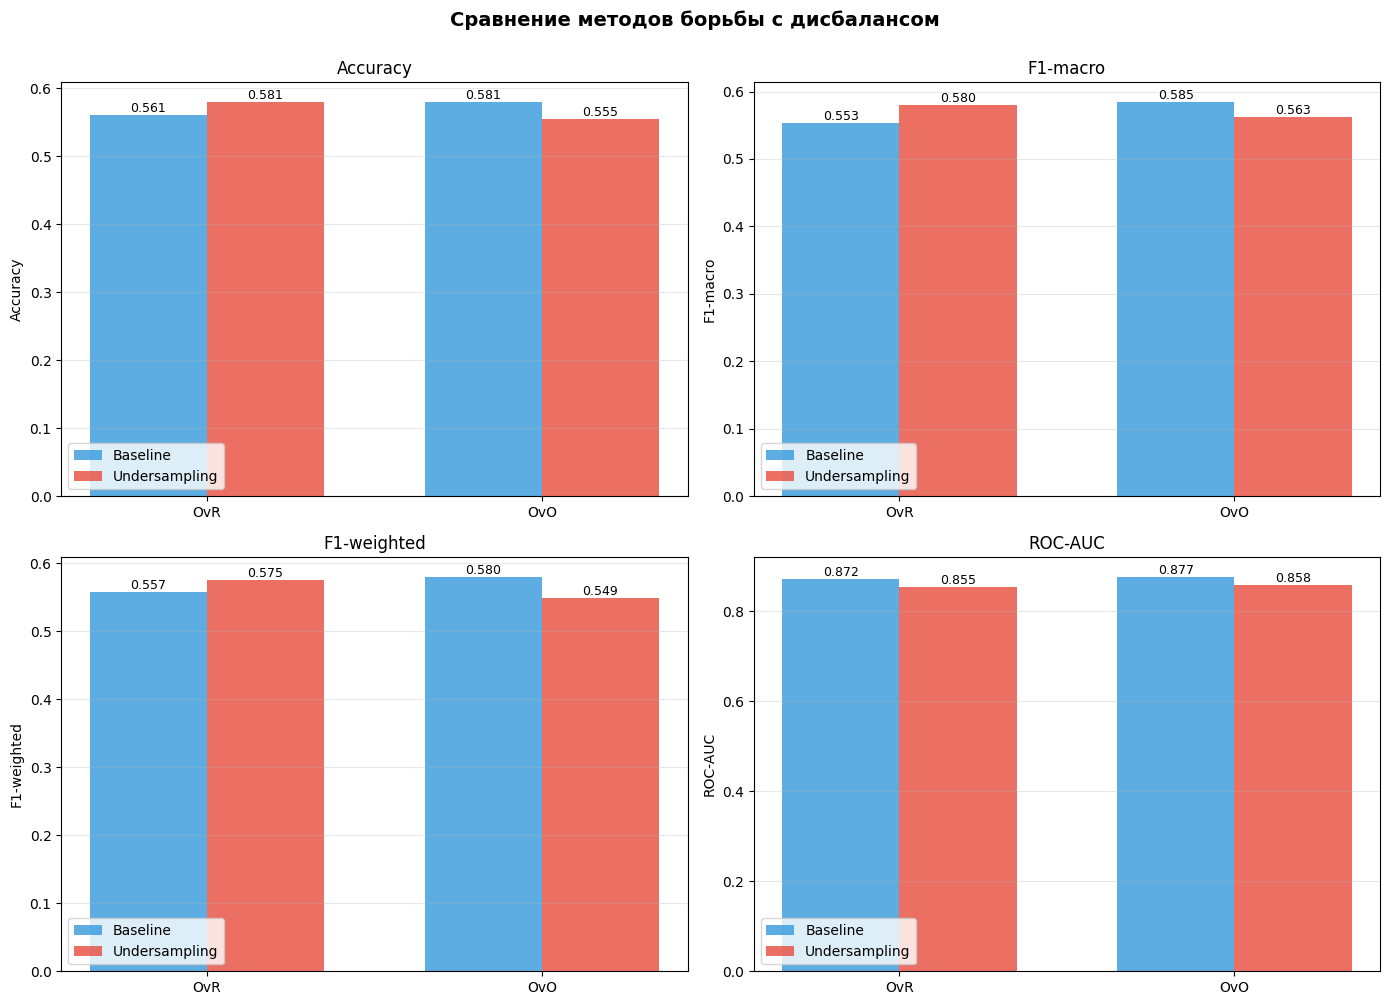


=== СРАВНЕНИЕ BASELINE VS UNDERSAMPLING ===

Accuracy:
  Baseline OvR:      0.5613
  Undersampling OvR: 0.5806  (↑ 0.0194)
  Baseline OvO:      0.5806
  Undersampling OvO: 0.5548  (↓ 0.0258)

F1-macro:
  Baseline OvR:      0.5528
  Undersampling OvR: 0.5797  (↑ 0.0269)
  Baseline OvO:      0.5851
  Undersampling OvO: 0.5628  (↓ 0.0223)

F1-weighted:
  Baseline OvR:      0.5574
  Undersampling OvR: 0.5753  (↑ 0.0179)
  Baseline OvO:      0.5801
  Undersampling OvO: 0.5490  (↓ 0.0311)

ROC-AUC:
  Baseline OvR:      0.8723
  Undersampling OvR: 0.8548  (↓ 0.0175)
  Baseline OvO:      0.8767
  Undersampling OvO: 0.8583  (↓ 0.0185)


In [74]:
plot_imbalance_comparison(res_imb_baseline_ovr, res_imb_baseline_ovo, res_imb_under_ovr, res_imb_under_ovo)

# Выводы по работе
## 1. Реализация методов One-vs-Rest и One-vs-One
Успешно реализованы оба подхода на основе бинарной логистической регрессии
OvR (One-vs-Rest): обучено 6 бинарных классификаторов (по одному на каждый класс)
OvO (One-vs-One): обучено 15 бинарных классификаторов (для всех пар классов)

Особенности реализации:
- OvR: каждый классификатор отделяет один класс от всех остальных
- OvO: каждый классификатор различает пару классов, финальное решение принимается голосованием
- Оба метода используют `StandardScaler` для нормализации признаков
## 2. Метрики для оценки многоклассовых моделей
Реализованы все требуемые метрики
### На сбалансированных данных:
| Метрика  | OvR  | OvO  |
| -------- | ---- | ---- |
| Accuracy | 0.54 | 0.57 |
| F1-macro | 0.54 | 0.57 |
| ROC-AUC  | 0.85 | 0.86 |
| PR-AUC   | 0.62 | 0.62 |

OvO показывает немного лучшие результаты на сбалансированных данных
Обе модели демонстрируют высокое качество (ROC-AUC > 0.85)
F1-macro показывает сбалансированную производительность по всем классам
## 3. Сравнение эффективности методов

| Метод | Время обучения   | Количество моделей |
| ----- | ---------------- | ------------------ |
| OvR   | 374 ms ± 16.7 ms | 6                  |
| OvO   | 774 ms ± 19.5 ms | 15                 |

Вывод: OvR оказался быстрее в ~2 раза, т.к. меньшее количество классификаторов. Несмотря на то, что каждый OvO-классификатор обучается на меньшем подмножестве данных (только два класса). Метрики рассмотрены в п. выше.

## 4. Анализ несбалансированности классов
Коэффициент дисбаланса: 2.62:1 (класс 3: 168 примеров vs класс 0: 64 примеров) - сильный дисбаланс, на него разные методы отреагировали по разному:
1. Undersampling улучшил OvR: F1-macro вырос на 2.7%, что указывает на лучшую работу с minority классами
2. Undersampling ухудшил OvO: все метрики снизились, что связано с потерей информации при уменьшении выборки и особенностях архитектуры
3. ROC-AUC немного снизился для обоих методов после undersampling, что ожидаемо из-за потери данных
4. Разница F1-macro и F1-weighted: baseline показывает большую разницу между этими метриками, что подтверждает проблему дисбаланса

При малом количестве данных можно применять более продвинутые решения: Применять SMOTE (oversampling) вместо undersampling для сохранения информации; Комбинировать oversampling minority классов с undersampling majority классов (SMOTEENN); Использовать стратифицированную кросс-валидацию. Нельзя: Чистый undersampling при небольшом объеме данных (потеря информации); Игнорирование дисбаланса (приводит к bias в сторону majority классов)

Также хочется отметить, что разные метрики могут по-разному оценивать класс. То есть, если, например, брать задачу бинарной классификации, где какого-то одного класса слишком много, Тогда модель может начать предсказывать только мажоритарный класс и совсем опустить признаки минорного класса. То есть у нас, по сути, получится предсказатель, который предсказывает только один класс, что неэффективно. Соответственно, эту проблему решают более продвинутые метрики, например, F1. На мультикласс рассматриваем F1 макро или F1 взвешенную.